# drifters simulation in an extracted zone of llc4320
different sites under crossroads of swot trajectories (site)    
several release of drifters (dl)


In [1]:
import os, shutil

import math
import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime

#import geopandas

import dask
#from dask.delayed import delayed

#from xmitgcm.llcreader import llcmodel as llc

%matplotlib inline
from matplotlib import pyplot as plt

from parcels import FieldSet, ParticleSet, ParticleFile, plotTrajectoriesFile, Variable
from parcels import JITParticle, ScipyParticle
from parcels import ErrorCode, NestedField, AdvectionEE, AdvectionRK4

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster

# ** processes and cores may be adjusted in order to have more memory or inversely more 
# ** computational ressource

processing = 1

if processing==0:
    cluster = LocalCluster()
elif processing==1:
    # parcels simulation
    cluster = PBSCluster(processes=4, cores=4, walltime='48:00:00')
#    w = cluster.scale(jobs=13)
    w = cluster.scale(jobs=1)
elif processing==2:
    # post processing
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
    
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.245:8787/status,
Dashboard: http://10.148.0.245:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.245:58401,Workers: 0
Dashboard: http://10.148.0.245:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---
## setup input parameters

In [3]:
# site directories
root_dir = '/home1/scratch/slgentil/parcels/'
site = 'californie'
dl = 16
speed = 5

---
## setup simulation parameters

In [4]:
# simulation parameters
run_name = site
simu_name = 'dl'+str(dl)+'.speed'+str(speed)

T = 30. # length of the simulation [days]
dt_outputs = timedelta(hours=1.) # time between two storages of floats  [hour]
dt_step = timedelta(hours=1.) # time step [hour]
dt_window = timedelta(days=T) 

overwrite = False

if site == 'californie':
    lonmin=-127.
    lonmax=-124.
    latmin=34
    latmax=37

---

## create tiles

*Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant with criterium on Depth or SST*

See `rearrange.ipynb` and `tile.ipynb` for more details

In [5]:
# create run directory tree
dirs = pa.create_dir_tree(root_dir, run_name, overwrite=overwrite)

Not overwriting /home1/scratch/slgentil/parcels/californie
Not overwriting /home1/scratch/slgentil/parcels/californie/run
Not overwriting /home1/scratch/slgentil/parcels/californie/tiling
Not overwriting /home1/scratch/slgentil/parcels/californie/parquets
Not overwriting /home1/scratch/slgentil/parcels/californie/diagnostics


In [6]:
create_tiles = False
#create_tiles = overwrite

if create_tiles:
    # create tiling
    _ds = grd.reset_coords().persist()
    tl = pa.tiler(ds=_ds, factor=(1, 1), overlap=(250, 250), 
                  global_llc=False, lonmin=lonmin, lonmax=lonmax, latmin=latmin, latmax=latmax)
    # store tiler
    tl.store(dirs["tiling"])
else:
    tl = pa.tiler(tile_dir=dirs["tiling"])

In [7]:
tl.create_tile_run_tree(dirs["run"], overwrite=overwrite)

Not overwriting /home1/scratch/slgentil/parcels/californie/run/data_000


---
## build tool to compute initial positions¶

In [8]:
# compute mid point
mid = lambda a, b: dict(lon = (a["lon"]+b["lon"])*.5,
                        lat = (a["lat"]+b["lat"])*.5,
                       )
def follow_path(lon, lat, dl, speed):
    """ Build a trajectory with dl (nautical miles) along the lon, lat paths
    
    Parameters
    ----------
    lon, lat: lists
        List of reference positions
    dl: float
        Distance between drifter release
    speed: float
        Speed of the ship in knots (nautical miles per hour)
    Returns
    -------
    lon_i, lat_i: lists
        Lists of release positions
    time: list
        Release deployment time in hours
    """
    hour2second = 3600.
    r = np.cos(np.pi/180.*np.mean(lat))
    time = [0.]
    for i in range(len(lon)-1):
        dlon = lon[i+1]-lon[i]
        dlat = lat[i+1]-lat[i]
        dl_segment = np.sqrt(dlon**2 * r**2 + dlat**2) # in deg
        ds = dl/60/dl_segment
        if i==0:
            lon_i, lat_i = [lon[0] - dlon * ds/2], [lat[0] - dlat * ds/2]
        s = 0
        while s<1:
            _lon = lon_i[-1] + dlon * ds
            _lat = lat_i[-1] + dlat * ds
            lon_i.append( _lon )
            lat_i.append( _lat )
            time.append( math.ceil(time[-1] + dl/speed) )
            s += ds
            #flag = ( (_lon-lon[i]) * (_lon-lon[i+1]) < 0 ) | ( (_lat-lat[i]) * (_lat-lat[i+1]) < 0 )
    return np.array(lon_i), np.array(lat_i), np.array(time) * timedelta(hours=1).total_seconds()


In [9]:
# corners of the eastern cross-over diamond

if site == 'californie':
    south = dict(lon=-125, lat=34.61)
    north = dict(lon=-125, lat=36.8)
    west = dict(lon=-125.3, lat=35.7)
    east = dict(lon=-124.7, lat=35.7)
    
lon_i, lat_i = [], []

lon_i.append(mid(west, north)["lon"])
lat_i.append(mid(west, north)["lat"])

lon_i.append(mid(east, south)["lon"])
lat_i.append(mid(east, south)["lat"])

lon_i.append(mid(west, south)["lon"])
lat_i.append(mid(west, south)["lat"])

lon_i.append(mid(east, north)["lon"])
lat_i.append(mid(east, north)["lat"])

In [10]:
lon, lat, time = follow_path(lon_i, lat_i, dl, speed)
print(time)

[     0.  14400.  28800.  43200.  57600.  72000.  86400. 100800. 115200.
 129600. 144000. 158400.]


--- 

## loop over time windows (main loop)

** we will probably need a restart mechanism the loop from a given time, it may be as simple as changing `np.arange(0,T, dt_windows)` into `np.arange(t_restart,T, dt_windows)`

** we may need to manually clear memory (for example if llc dataset has been persisted within tile_store_llc)


In [11]:
def format_info(step, t_start, t_end):
    print('-------------------------------------------')
    print('step={}  /  start={}  /  end={}'
          .format(step,
                  t_start.strftime("%Y-%m-%d:%H"),
                  t_end.strftime("%Y-%m-%d:%H"),
                 )
         )

In [12]:
tile = 0
step = 0
restart = 0

# load, tile form llc.nc file (without face dimension)
ds_tile = pa.load_ds_tile(tl)[0]

t_start = ut.np64toDate(ds_tile['time'][0].values)
t_end = t_start + dt_window + dt_step
format_info(step, t_start, t_end)

# get new log filename for this run
log_file = pa.name_log_file(dirs['run'])

# clean up data for restart
tl.clean_up(dirs["run"], restart)

local_numbers = {tile: 0 for tile in range(tl.N_tiles)}
max_ids = {tile: None for tile in range(tl.N_tiles)}

#for tile in range(tl.N_tiles):
tile = 0
step_out = \
        pa.step_window(tile, step, 
                       t_start, t_end,
                       dt_window, dt_step, dt_outputs, 
                       tl,
                       ds_tile=ds_tile,  
                       lon=lon, lat=lat, time=time, 
                       parcels_remove_on_land=True,
                       pclass="extended",
                       id_max=max_ids[tile],
                      )

max_ids = {tile: int(step_out[1])}
local_numbers = {tile: int(step_out[0])}
log = dict(
           local_numbers=local_numbers,
           max_ids=max_ids,
          )

# store log
pa.store_log(log_file, step, log)

print('Total number of particles start/end= {}/{}'
      .format(lon.size,local_numbers[0])
     )
    

-------------------------------------------
step=0  /  start=2011-11-15:00  /  end=2011-12-15:01


INFO: Compiled ArrayParticle_extendedRemoveOnLand ==> /dev/shm/pbs.6667360.datarmor0/parcels-16088/libca96cffef71a113276a319842bdde1c2_0.so
INFO: Compiled ArrayParticle_extendedExtended_SampleAdvectionRK4 ==> /dev/shm/pbs.6667360.datarmor0/parcels-16088/lib40c2f96cd4c07f92f2b39cbb83ef7ac0_0.so
INFO: Temporary output files are stored in /home1/scratch/slgentil/parcels/californie/run/data_000/out-PLASUJOQ.
INFO: You can use "parcels_convert_npydir_to_netcdf /home1/scratch/slgentil/parcels/californie/run/data_000/out-PLASUJOQ" to convert these to a NetCDF file during the run.
100% (2595600.0 of 2595600.0) |##########| Elapsed Time: 0:00:14 Time:  0:00:14
/home1/datahome/slgentil/conda-env/test/lib/python3.8/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' whe

Total number of particles start/end= 12/2


In [13]:
print(log_file)

/home1/scratch/slgentil/parcels/californie/run/log_20210909_0613.yaml


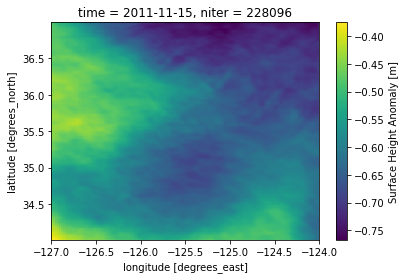

In [14]:
ds_tile.Eta.isel(time=0).plot.pcolormesh(x='XC',y='YC')

In [15]:
#ds_tiles = [_ds.persist() for _ds in ds_tiles]
# 220GB in RAM against 750 GB observed

Change name of the floats netcdf file according to the simulation name. The goal is to keep the same llc.nc file for several simulations, with different float releases

In [16]:
run_dir = dirs['run']
f = os.path.join(run_dir, "data_000/floats_000_000.nc")
if os.path.isfile(f):
    f_new = f.replace('000_000',simu_name)
    os.rename(f, f_new)

Plot trajectories

In [17]:
df = pa.load_nc(dirs["run"], index='time', step_tile=simu_name, persist=True)
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15 00:00:00,0,36.380151,-125.185658,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2011-11-15 01:00:00,0,36.372983,-125.177441,0.0,2.319549e-06,-0.000002,-0.696997,13.406317,33.160259
2011-11-15 02:00:00,0,36.365401,-125.171495,0.0,2.253178e-06,-0.000002,-0.719081,13.392070,33.157738
2011-11-15 03:00:00,0,36.357647,-125.167873,0.0,1.168528e-06,-0.000002,-0.621342,13.367542,33.133263
2011-11-15 04:00:00,0,36.352578,-125.165383,0.0,8.287934e-07,-0.000002,-0.387230,13.370584,33.147820


In [18]:
tmin = str(df.index.min().compute() )
tmax = str(df.index.max().compute())
print(tmin, tmax)

2011-11-15 00:00:00 2011-12-15 01:00:00


In [19]:
tmin = str(df.index.min().compute())
tmax = str(df.index.max().compute())
tplt = str(df.index.min().compute() + timedelta(seconds=time[-1]))
print(tmin, tmax, tplt)

2011-11-15 00:00:00 2011-12-15 01:00:00 2011-11-16 20:00:00


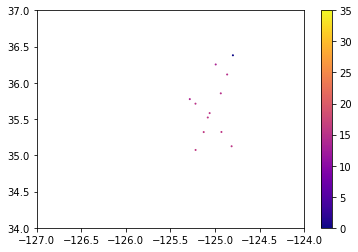

In [20]:

_df = df.loc[tplt].compute()
plt.scatter(_df['lon'], _df['lat'], s=1, c=_df['temperature'], 
            vmin=0, vmax=35, cmap='plasma')
plt.xlim(lonmin,lonmax)
plt.ylim(latmin,latmax)
plt.colorbar()

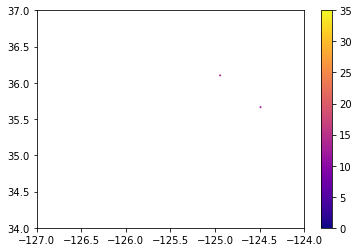

In [21]:
_df = df.loc[tmax].compute()
plt.scatter(_df['lon'], _df['lat'], s=1, c=_df['temperature'], 
            vmin=0, vmax=35, cmap='plasma')
plt.xlim(lonmin,lonmax)
plt.ylim(latmin,latmax)
plt.colorbar()

plot trajectories of the simulation

In [22]:
f = os.path.join(dirs['run'], "data_000/floats_{}.nc".format(simu_name))
ds = xr.open_dataset(f)
df = ds.to_dataframe()
print(df.columns)
ts = df['time'].min()
te = df['time'].max()
t_range = pd.date_range(ts, te, freq="1H")
print(t_range)

Index(['trajectory', 'time', 'lat', 'lon', 'z', 'zonal_velocity',
       'meridional_velocity', 'sea_level', 'temperature', 'salinity'],
      dtype='object')
DatetimeIndex(['2011-11-15 00:00:00', '2011-11-15 01:00:00',
               '2011-11-15 02:00:00', '2011-11-15 03:00:00',
               '2011-11-15 04:00:00', '2011-11-15 05:00:00',
               '2011-11-15 06:00:00', '2011-11-15 07:00:00',
               '2011-11-15 08:00:00', '2011-11-15 09:00:00',
               ...
               '2011-12-14 16:00:00', '2011-12-14 17:00:00',
               '2011-12-14 18:00:00', '2011-12-14 19:00:00',
               '2011-12-14 20:00:00', '2011-12-14 21:00:00',
               '2011-12-14 22:00:00', '2011-12-14 23:00:00',
               '2011-12-15 00:00:00', '2011-12-15 01:00:00'],
              dtype='datetime64[ns]', length=722, freq='H')


In [23]:
print(df.index)

MultiIndex([( 0,   0),
            ( 0,   1),
            ( 0,   2),
            ( 0,   3),
            ( 0,   4),
            ( 0,   5),
            ( 0,   6),
            ( 0,   7),
            ( 0,   8),
            ( 0,   9),
            ...
            (11, 712),
            (11, 713),
            (11, 714),
            (11, 715),
            (11, 716),
            (11, 717),
            (11, 718),
            (11, 719),
            (11, 720),
            (11, 721)],
           names=['traj', 'obs'], length=8664)


## Close cluster

In [24]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
